# Simple CNN on MNIST - Generalization

In [1]:
import numpy as np

import os

import keras
from keras import backend
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model

import tensorflow as tf

from keras.callbacks import TensorBoard, EarlyStopping

from cleverhans.utils_mnist import data_mnist
from cleverhans.attacks import (BasicIterativeMethod, CarliniWagnerL2, DeepFool, ElasticNetMethod, 
                                FastFeatureAdversaries, FastGradientMethod, LBFGS, MadryEtAl, 
                                MomentumIterativeMethod, SPSA, SaliencyMapMethod, VirtualAdversarialMethod)
from cleverhans.utils_keras import KerasModelWrapper

from ipywidgets import interact
import ipywidgets as widgets

/home/Chris/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [3]:
from_saved_model = True
run_attack = True

## Configurable Parameters

In [4]:
# Used in Getting the Data
train_start=0
train_end=60000
test_start=0
test_end=10000

attack_start=0
attack_end=100

batch_size = 128
num_classes = 10
epochs = 500
input_shape = (28, 28, 1)

gen_steps = 11

num_points = 10
attack_names = ['basic_iterative', 'fast_gradient', 'madry', 'momentum_iterative']

run_ident = '18'

In [5]:
losses = np.zeros((gen_steps, len(attack_names), num_points))
accuracies = np.zeros((gen_steps, len(attack_names), num_points))

for gen in range(gen_steps):
    loss = np.load('results_r{}/loss_g{}.npy'.format(run_ident, gen))
    accuracy = np.load('results_r{}/accuracy_g{}.npy'.format(run_ident, gen))
    
    losses[gen,:,:] = loss
    accuracies[gen,:,:] = accuracy

In [8]:
def plot_func(gen):
    fig = plt.figure(figsize=(8, 6))
    plt.subplot(121)
    for index, attack_name in enumerate(attack_names):
        x_plt = np.linspace(0, 0.5, num_points)
        y_plt = losses[gen, index, :].flatten()
        plt.plot(x_plt, y_plt, label=attack_name)
    plt.title('Adversarial Loss')
    plt.xlabel('Attack Strength')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(122)
    for index, attack_name in enumerate(attack_names):
        x_plt = np.linspace(0, 0.5, num_points)
        y_plt = accuracies[gen, index, :].flatten()
        plt.plot(x_plt, y_plt, label=attack_name)
    plt.title('Adversarial Accuracy')
    plt.xlabel('Attack Strength')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [9]:
if run_attack:
    interact(plot_func, gen=widgets.IntSlider(min=0,max=gen_steps-1,step=1,value=0));

interactive(children=(IntSlider(value=0, description='gen', max=10), Output()), _dom_classes=('widget-interact',))

In [39]:
np.savetxt('losses_g0_r{}.csv'.format(run_ident), losses[0, :, :].T, delimiter=',')
np.savetxt('accuracies_g0_r{}.csv'.format(run_ident), accuracies[0, :, :].T, delimiter=',')
np.savetxt('losses_g1_r{}.csv'.format(run_ident), losses[1, :, :].T, delimiter=',')
np.savetxt('accuracies_g1_r{}.csv'.format(run_ident), accuracies[1, :, :].T, delimiter=',')

In [33]:
losses_sum = np.sum(losses, axis=2)
accuracies_sum = np.sum(accuracies, axis=2)

losses_rel = np.zeros((gen_steps, len(attack_names)))
accuracies_rel = np.zeros((gen_steps, len(attack_names)))

for index, attack_name in enumerate(attack_names):
    for gen in range(gen_steps):
        losses_all = losses[gen, index, :].flatten()
        losses_rel[gen, index] = np.sum(losses_all)
                                        
        accuracies_all = accuracies[gen, index, :].flatten()
        accuracies_rel[gen, index] = np.sum(accuracies_all)

In [36]:
np.savetxt('losses_rel_r{}.csv'.format(run_ident), losses_rel, delimiter=',')
np.savetxt('accuracies_rel{}.csv'.format(run_ident), accuracies_rel, delimiter=',')

In [34]:
print(losses_rel)

[[122.52405384  80.97381611 122.61464866 122.27383342]
 [145.60232885 128.30078081 145.44267248 145.60385351]
 [145.98366561 131.45183753 144.04949325 145.98366561]
 [147.81462389 135.80532763 141.68974535 147.81462389]
 [147.76416777 125.78831247 144.70172857 147.76416777]
 [145.92247223 131.89255188 145.04523621 147.81737335]
 [149.49776025 147.1450512  149.49776025 149.49776025]
 [152.12035934 146.28004593 151.31445419 152.12035934]
 [149.41995579 141.7432151  150.63458069 152.62387302]
 [135.77529358 124.1681855  145.69170807 139.38008789]
 [158.60890755 156.45368813 158.28654549 158.60890755]]


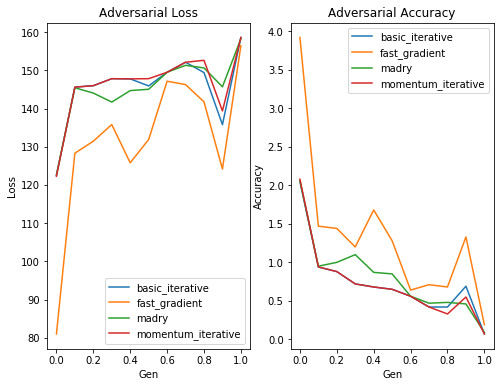

In [35]:
fig = plt.figure(figsize=(8, 6))

losses_start = losses[:, :, 0]
losses_sum = np.sum(losses, axis=2)

plt.subplot(121)
for index, attack_name in enumerate(attack_names):
    x_plt = np.linspace(0, 1, num=gen_steps)
    y_plt = losses_rel[:, index].flatten()
    plt.plot(x_plt, y_plt, label=attack_name)
plt.title('Adversarial Loss')
plt.xlabel('Gen')
plt.ylabel('Loss')
plt.legend()

accuracies_sum = np.sum(accuracies, axis=2)

plt.subplot(122)
for index, attack_name in enumerate(attack_names):
    x_plt = np.linspace(0, 1, num=gen_steps)
    y_plt = accuracies_rel[:, index].flatten()
    plt.plot(x_plt, y_plt, label=attack_name)
plt.title('Adversarial Accuracy')
plt.xlabel('Gen')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [43]:
print(np.linspace(0, 0.5, 10))

[0.         0.05555556 0.11111111 0.16666667 0.22222222 0.27777778
 0.33333333 0.38888889 0.44444444 0.5       ]
